# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 19.0.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r19-0-0`.

### Test case LVV-T41: Verify implementation of Generate PSF for Visit Images
Verify that Processed Visit Images produced by the DRP and AP pipelines are associated with
a model from which one can obtain an image of the PSF given a point on the image.

In [1]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r19-0-0
lsst_distrib          19.0.0+2   	current v19_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afw_display
import lsst.geom as geom
from lsst.afw.image import Exposure, Image, PARENT

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2019_46`, which is the pipelines version that was used to create `v19_0_0`.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-22223":

rc2_repo = '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223'

In [6]:
# Initialize the butler repo:
butler = dafPersist.Butler(rc2_repo)
#m31_fields = butler.subset('calexp', filter='HSC-R', field='M31')

# Make a glob of the files in the repo, so we can parse this to get tract/patch IDs:
infiles = glob.glob(rc2_repo+'/deepCoadd/HSC-R/*/*/warp-*.fits')
#infiles = glob.glob(rc2_repo+'/deepCoadd-results/HSC-R/*/*/calexp-*.fits')
print(len(infiles))

2117


In [7]:
tract_array = []
patch_array = []
visit_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223/deepCoadd/HSC-R/9615/8,8/warp-HSC-R-9615-8,8-23902.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):

#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'RC',
# 'w_2019_46',
# 'DM-22223',
# 'deepCoadd',
# 'HSC-R',
# '9615',
# '8,8',
# 'warp-HSC-R-9615-8,8-23902.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])
    # Split the file name to extract the visit number:
    file_str = parts[-1]
    file_str2 = file_str.split('.fits')
    file_str3 = file_str2[0].split('-')
    visit_array.append(file_str3[-1])

print('Found %i patches'%(len(patch_array)))
        
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array,
        'visit': visit_array}
df_tract_patch_visit = pd.DataFrame(data=data)

Found 2117 patches


In [8]:
# df_tract_patch_visit

In [9]:
# Check the tract names that are available:
print(df_tract_patch_visit.tract.unique())

[9615 9813 9697]


The repo consists of three visits: 9615, 9697, and 9813.

In [10]:
# Select some visit/tract/patch combinations from these at random:
numvisits = 12
patch_sel = df_tract_patch_visit.sample(numvisits)

In [11]:
patch_sel

,tract,patch,visit
582,9813,"6,7",1208
425,9615,"1,4",23872
215,9615,"3,3",23872
435,9615,"5,1",23898
324,9615,"8,2",23868
679,9813,"4,2",23692
235,9615,"7,0",23914
51,9615,"2,6",23872
684,9813,"4,2",1214
928,9813,"3,7",1212


In [12]:
# CCDs number from 0-111. Randomly select a CCD for each of the visits:
ccdnums = np.random.randint(112, size=numvisits)

# CCD 9 is bad, so generate a new array until we have no "9" values in it:
exclude_ccds = [9]
while ccdnums.any() in exclude_ccds:
    ccdnums = np.random.randint(112, size=numvisits)

In [13]:
ccd_id = 0
calexps = []
datarefs = []

for row, vis in patch_sel.iterrows():
    # print(vis)
    # Note: we are using only the 'HSC-R' filter for this, but other filters could be selected:
    dataref = {'tract':int(vis.tract),'visit':int(vis.visit), 'ccd':int(ccdnums[ccd_id])}
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('calexp', dataId = dataref):
        calexp = butler.get('calexp', dataId = dataref)
        ccd_id += 1
        calexps.append(calexp)
        datarefs.append(dataref)
    else:
        okccd = False
        while okccd==False:
            new_ccdnum = np.random.randint(112, size=1)
            dataref['ccd'] = int(new_ccdnum[0])
            if butler.datasetExists('calexp', dataId = dataref): 
                okccd = True
        calexp = butler.get('calexp', dataId = dataref)
        ccd_id += 1
        calexps.append(calexp)
        datarefs.append(dataref)        


In [14]:
datarefs

[{'tract': 9813, 'visit': 1208, 'ccd': 0},
 {'tract': 9615, 'visit': 23872, 'ccd': 59},
 {'tract': 9615, 'visit': 23872, 'ccd': 86},
 {'tract': 9615, 'visit': 23898, 'ccd': 101},
 {'tract': 9615, 'visit': 23868, 'ccd': 79},
 {'tract': 9813, 'visit': 23692, 'ccd': 92},
 {'tract': 9615, 'visit': 23914, 'ccd': 67},
 {'tract': 9615, 'visit': 23872, 'ccd': 71},
 {'tract': 9813, 'visit': 1214, 'ccd': 30},
 {'tract': 9813, 'visit': 1212, 'ccd': 48},
 {'tract': 9615, 'visit': 23872, 'ccd': 103},
 {'tract': 9697, 'visit': 34734, 'ccd': 47}]

Note that a simple way to confirm that a given `calexp` image has a PSF is via the method: `calexp.hasPsf()`.

#### For each of the selected visit/tract/patch/CCD combinations, pick a random (X,Y) coordinate, extract the PSF, and plot an image of the PSF.

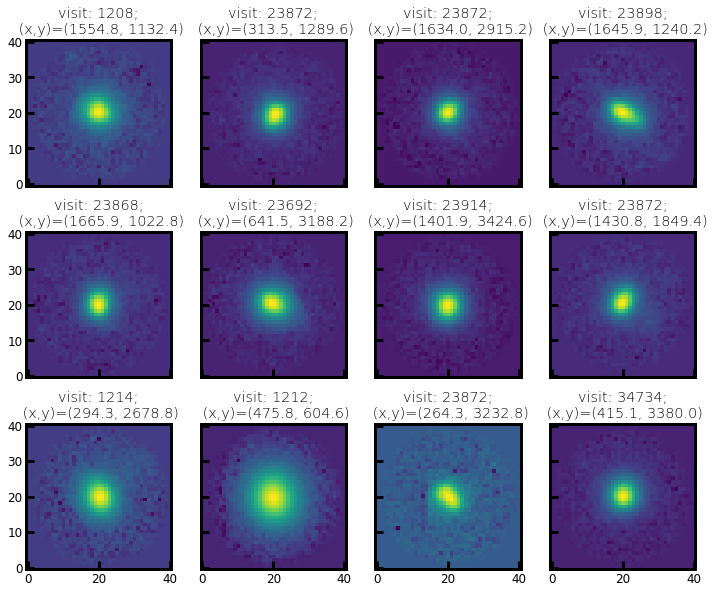

In [15]:
ncols = 4
nrows = numvisits/ncols # 4 plots per row
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axnum = 0
axs = ax.flatten()

for c in calexps:
#    print(c.hasPsf())
    psf = c.getPsf()
    xsize = c.getDimensions().getX()
    ysize = c.getDimensions().getY()
    # Select a random point on the image and extract the PSF at that point:
    xpt = random.random()*xsize
    ypt = random.random()*ysize
    psfimage = psf.computeImage(geom.PointD(xpt, ypt))
    img = psfimage.array

    # Create an ImageNormalize object
    norm = ImageNormalize(img, interval=MinMaxInterval(),
                          stretch=LogStretch())

#    axs[axnum].set_xlim(psfimage.getX0(),psfimage.getX0()+psfimage.getDimensions()[0])
#    axs[axnum].set_ylim(psfimage.getY0(),psfimage.getY0()+psfimage.getDimensions()[1])
    axs[axnum].set_title('visit: '+patch_sel.iloc[axnum].visit+';\n (x,y)=('+str(round(xpt,1))+', '+str(round(ypt,1))+')')
    axs[axnum].imshow(img, norm=norm, origin='lower')
    axnum += 1


### Now confirm that the PSF is reasonably well-matched to stellar images by selecting a star in each image and subtracting the PSF at the star's position:

In [16]:
# Pick a bright star that was used to fit the PSF, and one that was used to calibrate the photometry:
src = butler.get('src', dataId=dataref)

# Select a PSF and photometric calibration stars:
psf_selection = src['calib_psf_used']
photcalib_selection = src['calib_photometry_used']

# Pick one from each table at random:
psf_src = random.choice(src[psf_selection])
photcalib_src = random.choice(src[photcalib_selection])

In [17]:
radec_psf_src = psf_src.getCoord()

In [18]:
wcs = c.getWcs()

cutoutSize = geom.ExtentI(100, 100) # size of cutout in pixels
xy = geom.Point2I(wcs.skyToPixel(radec_psf_src)) # central XY coordinate of our star's RA, Dec position

# Create the bounding box:
bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

# Full patch image
#image = butler.get('calexp', immediate=True, dataId=dataid)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0 = c.getXY0() 

# Postage stamp image only, using the bbox defined above:
cutout_image = butler.get('calexp_sub', bbox=bbox, immediate=True, dataId=dataref).getMaskedImage()
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_cutout = cutout_image.getXY0() 

In [19]:
psf = c.getPsf()
model = Exposure(cutout_image.getBBox(), dtype=np.float32)
model.setPsf(psf)
psfImage = psf.computeImage(psf_src.getCentroid())
flux = psf_src['base_PsfFlux_instFlux']-(psf_src['base_PsfFlux_area']*psf_src['base_LocalBackground_instFlux'])
psfBBox = psfImage.getBBox()
model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
residuals = cutout_image.clone()
residuals.image -= model.image

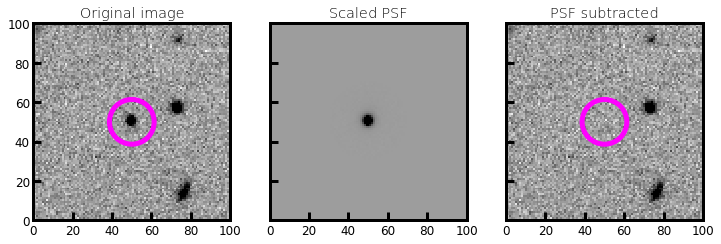

In [20]:
f, ax = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12,6))
axs = ax.flatten()

vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
axs[0].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[0].set_xlim(0,imsize[0])
axs[0].set_ylim(0,imsize[1])
axs[0].set_title('Original image')
axs[0].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)

# Get the dimensions of the image so we can set plot limits
imsize = model.image.getDimensions()
axs[1].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[1].set_xlim(0,imsize[0])
axs[1].set_ylim(0,imsize[1])
axs[1].set_title('Scaled PSF')

# Get the dimensions of the image so we can set plot limits
imsize = residuals.image.getDimensions()
axs[2].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[2].set_xlim(0,imsize[0])
axs[2].set_ylim(0,imsize[1])
axs[2].set_title('PSF subtracted')
axs[2].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)



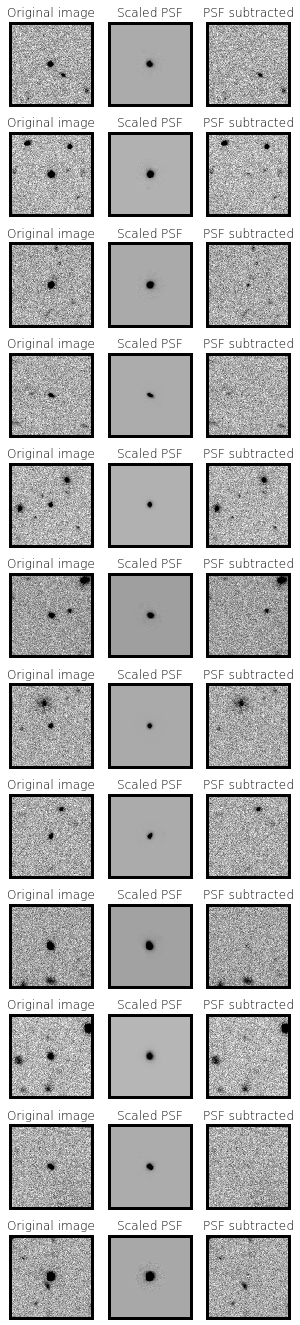

In [21]:
ncols = 3
nrows = numvisits # 4 plots per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5,24))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for i in range(len(calexps)):
# for c in calexps:
    c = calexps[i]
    dataid = datarefs[i]
    # Pick a bright star that was used to fit the PSF:
    src = butler.get('src', dataId=dataid)

    # Get the WCS for this calexp:
    wcs = c.getWcs()

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)

    # Select a PSF star:
    psf_selection = src['calib_psf_used']

    # Pick one from the table at random, but require it to have coordinates
    #   such that the bounding box will not extend beyond the CCD's border:
    oksrc = False
    while not oksrc:
        calexp_dimen = c.getDimensions()
        psf_src = random.choice(src[psf_selection])
        xy = psf_src.getCentroid()
        if (xy.getX() > imsize/2.0) and (xy.getX() < calexp_dimen[0]-imsize/2.0) and\
           (xy.getY() > imsize/2.0) and (xy.getY() < calexp_dimen[1]-imsize/2.0):
            oksrc = True

            
    xy = geom.Point2I(xy)

    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # Postage stamp image only, using the bbox defined above:
    cutout_image = butler.get('calexp_sub', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage()
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 
    
    psf = c.getPsf()
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(psf_src.getCentroid())
    flux = psf_src['base_PsfFlux_instFlux']-(psf_src['base_PsfFlux_area']*psf_src['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image
    
    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1



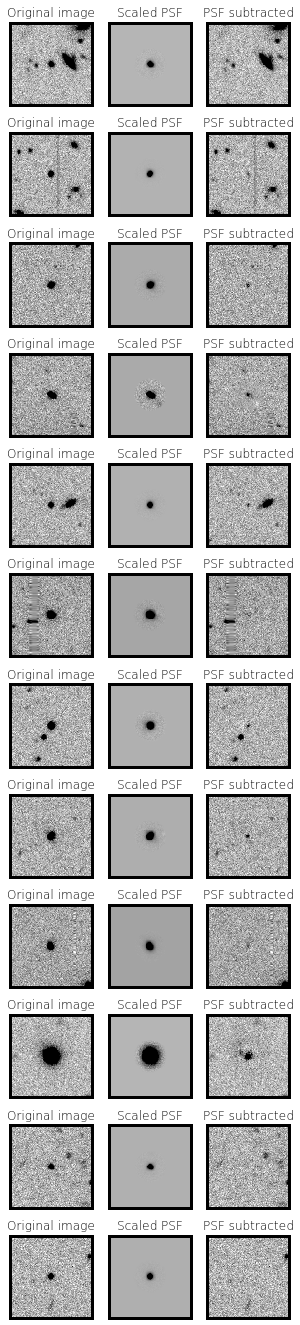

In [22]:
ncols = 3
nrows = numvisits # 4 plots per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5,24))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for i in range(len(calexps)):
# for c in calexps:
    c = calexps[i]
    dataid = datarefs[i]
    # Pick a bright star that was used to fit the PSF:
    src = butler.get('src', dataId=dataid)

    # Get the WCS for this calexp:
    wcs = c.getWcs()

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)

    # Select a photometric calibration star:
    photcalib_selection = src['calib_photometry_used']

    # Pick one from the table at random, but require it to have coordinates
    #   such that the bounding box will not extend beyond the CCD's border:
    oksrc = False
    while not oksrc:
        calexp_dimen = c.getDimensions()
        photcalib_src = random.choice(src[photcalib_selection])
        xy = photcalib_src.getCentroid()
        if (xy.getX() > imsize/2.0) and (xy.getX() < calexp_dimen[0]-imsize/2.0) and\
           (xy.getY() > imsize/2.0) and (xy.getY() < calexp_dimen[1]-imsize/2.0):
            oksrc = True

            
    xy = geom.Point2I(xy)

    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # Postage stamp image only, using the bbox defined above:
    cutout_image = butler.get('calexp_sub', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage()
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 
    
    psf = c.getPsf()
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(photcalib_src.getCentroid())
    flux = photcalib_src['base_PsfFlux_instFlux']-(photcalib_src['base_PsfFlux_area']*photcalib_src['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image
    
    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

